In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news/submit.csv
/kaggle/input/fake-news/train.csv
/kaggle/input/fake-news/test.csv


In [2]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [5]:
df = pd.read_csv('../input/fake-news/train.csv')

Data Preprocessing 

In [6]:
df.shape

(20800, 5)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [8]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [9]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [10]:
## according to have enough dataset we will fill null values with empty string 
df = df.fillna('')

In [11]:
df.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [12]:
## Data regularization we wiil combine author with tittle
df['Description'] = df['title'] + '' +df['author']

In [13]:
df[['Description']]

,Description
0,House Dem Aide: We Didn’t Even See Comey’s Let...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,Why the Truth Might Get You FiredConsortiumnew...
3,15 Civilians Killed In Single US Airstrike Hav...
4,Iranian woman jailed for fictional unpublished...
...,...
20795,Rapper T.I.: Trump a ’Poster Child For White S...
20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -..."
20797,Macy’s Is Said to Receive Takeover Approach by...
20798,"NATO, Russia To Hold Parallel Exercises In Bal..."


In [14]:
df = df.drop(columns =['title','author'])

In [15]:
df.head()

,id,text,label,Description
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You FiredConsortiumnew...
3,3,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


Stemming:

Stemming is the process of reducing a word to its Root word

In [16]:
port_stem = PorterStemmer()

In [17]:
def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]',' ',content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [18]:
df['Description'] = df['Description'].apply(stemming)

In [19]:
df['Description'] 

0        hous dem aid even see comey letter jason chaff...
1        flynn hillari clinton big woman campu breitbar...
2                   truth might get firedconsortiumnew com
3        civilian kill singl us airstrik identifiedjess...
4        iranian woman jail fiction unpublish stori wom...
                               ...                        
20795    rapper trump poster child white supremaci jero...
20796    n f l playoff schedul matchup odd new york tim...
20797    maci said receiv takeov approach hudson bay ne...
20798    nato russia hold parallel exercis balkansalex ...
20799                            keep f alivedavid swanson
Name: Description, Length: 20800, dtype: object

In [20]:
#split the data to x and y
x = df['Description'].values
y= df['label']

In [21]:
x.shape

(20800,)

In [22]:
y.shape

(20800,)

In [23]:
# converting the textual data to numerical data
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit(x)

x = vectorizer.transform(x)

In [24]:
print(x)

  (0, 21557)	0.2736369479869461
  (0, 18009)	0.2438301027041085
  (0, 11974)	0.34466883664274506
  (0, 11617)	0.2783091851108118
  (0, 10495)	0.311553446057155
  (0, 10381)	0.41343221816522613
  (0, 9475)	0.20871803491508256
  (0, 6798)	0.22134331972572915
  (0, 5178)	0.25645024223907936
  (0, 3933)	0.23592778464338887
  (0, 3291)	0.34851330509336254
  (0, 381)	0.25686395241555227
  (1, 23108)	0.2952143706864955
  (1, 9174)	0.18812765977413537
  (1, 7534)	0.6987204016565229
  (1, 3714)	0.18820851327454977
  (1, 2957)	0.37436858023248293
  (1, 2482)	0.3616637468521842
  (1, 1956)	0.2878737833766196
  (2, 21453)	0.41331452278016145
  (2, 12835)	0.4627692646157023
  (2, 8113)	0.3260098284202015
  (2, 7391)	0.6469324358467595
  (2, 3910)	0.30035267305096314
  (3, 21978)	0.23565193182482072
  :	:
  (20797, 23430)	0.08239795721216821
  (20797, 20788)	0.19858848268663878
  (20797, 19961)	0.32033450422171095
  (20797, 17564)	0.24595228419376997
  (20797, 16511)	0.2701082984026285
  (20797, 162

Splitting the dataset to training & test data****

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
x_train , x_test , y_train , y_test = train_test_split(x,y,test_size = .20 ,stratify=y, random_state=1)

Choose the right model

In [27]:
from sklearn.linear_model import LogisticRegression

In [28]:
model = LogisticRegression()

In [29]:
model.fit(x_train, y_train)

LogisticRegression()

In [30]:
#the accuracy score of training data 
model.score(x_train,y_train)

0.9826322115384616

In [31]:
y_predicted = model.predict(x_test)

In [32]:
from sklearn.metrics import accuracy_score

In [33]:
test_data_accuracy = accuracy_score(y_predicted,y_test)

In [34]:
#the accuracy score of testing data 
test_data_accuracy

0.965625

In [35]:
from sklearn.metrics import confusion_matrix

In [36]:
cm = confusion_matrix(y_test , y_predicted)

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

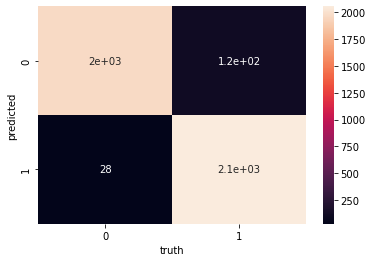

In [38]:
sns.heatmap(cm , annot =True)
plt.xlabel('truth')
plt.ylabel('predicted')
plt.show()